## VAE_Workbook.v1.2

### Part of my exploration of Latent Space through linear and nonlinear approaches. This notebook is an implementation of VAE and is part of ExploreLatentSpace, a notebook exploring and comparing the different methods of dimensionality reduction on machine learning data. 
### Author: Ashray Desai <br>Date: July 29, 2020

## System Information

<ul>
<li>OS: Windows 10 64-bit</li>
<li>CPU: Intel Core i7-6700HQ @ 2.60 GHz</li>
<li>GPU: Nvidia GeForce 940m @ 2.50 GHz</li>
<li>RAM: 8 GB DDR4</li>
<li>Python version: 3.6.4</li>
<li>Pandas version: 1.0.5</li>
<li>Tensorflow version: 1.15.0</li>
<li>Keras version: 2.3.1</li>
<li>Scikit-learn version: 0.22</li>
<li>NumPy version: 1.15</li>
<li>Time version: 3.7</li>
<li>Matplotlib version: 3.2.2</li>
<li>Seaborn version: 1.10.1</li>
</ul> 

## Summary
* Section 1 - Data Formatting
* Section 2 - Defining helpful functions
* Section 3 - Defining the VAE Neural Networks
* Section 4 - Training the Network
* Section 5 - Plotting Latent Space Results
* Section 6 - Analysis
* Section 5 - Conclusion

### Section 1: Data Formatting

In [44]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import keras
from keras.layers import Lambda, Input, Dense
from keras.models import Model
from keras.datasets import mnist
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model
from keras import backend as K

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import argparse
import os

In [34]:
'''A record of installed packages and some helpful terminal commands to replicate the setup I used.'''
#! pip install --upgrade pip setuptools wheel
#! pip install -I tensorflow
#! pip install -I keras
'''Installing collected packages: numpy, opt-einsum, zipp, importlib-metadata, markdown, pyasn1, pyasn1-modules, 
six, setuptools, rsa, cachetools, google-auth, tensorboard-plugin-wit, absl-py, wheel, protobuf, werkzeug, 
certifi, chardet, urllib3, idna, requests, oauthlib, requests-oauthlib, google-auth-oauthlib, grpcio, tensorboard, 
google-pasta, wrapt, astunparse, gast, tensorflow-estimator, h5py, scipy, keras-preprocessing, termcolor, tensorflow'''
#! pip install tensorflow==2.2.0
'''Successfully installed scipy-1.4.1 tensorboard-2.2.2 tensorflow-2.2.0 tensorflow-estimator-2.2.0''';

In [36]:
#Load either MNIST or Fashion MNIST Dataset

(input_train, target_train), (input_test, target_test) = mnist.load_data()
#(input_train, target_train), (input_test, target_test) = fashion_mnist.load_data()

In [37]:
# This notebook is part of a larger study involving latent space visualization methods such as t-SNE, which can take
# hours to process the entire MNIST or Fashion-MNIST dataset. Therefore, I have resized the data for t-SNE and must do so
# here as well to keep all variables consistent.

# Reshape data into a 28 by 28 numpy array to be processed
img_width, img_height = input_train.shape[1], input_train.shape[2]
input_train = input_train.reshape(input_train.shape[0], img_height * img_width)
input_test = input_test.reshape(input_test.shape[0], img_height * img_width)

# Parse numbers as floats + normalize
input_train = input_train.astype('float32') / 255
input_test = input_test.astype('float32') / 255

'''
Configure data into Pandas dataframe and sample a random portion of the data (using a common seed so that data
sampled is the same for the other methods)
''';
X = input_train #X and y are both numpy ndArrays
y = target_train

X_test = input_test #X and y are both numpy ndArrays
y_test = target_test

feat_cols = ['pixel' + str(i + 1) for i in range(X.shape[1])]
feat_cols_test = ['pixel' + str(i + 1) for i in range(X_test.shape[1])]

df = pd.DataFrame(X, columns=feat_cols)
df['label'] = y #apply labels to each dataframe entry
df_test = pd.DataFrame(X_test, columns=feat_cols_test)
df_test['label'] = y_test #apply labels to each dataframe entry

#Randomly samples a sample of the data, with a seed for reproduceability
numTrainingSamplesToUse = 8000
numTestSamplesToUse = 2000
np.random.seed(42)

rndperm = np.random.permutation(df.shape[0])
rndperm_test = np.random.permutation(df_test.shape[0])

df_subset = df.loc[rndperm[:numTrainingSamplesToUse],:].copy()
df_subset_test = df_test.loc[rndperm_test[:numTestSamplesToUse],:].copy()

train_subset = df_subset[feat_cols].values
test_subset = df_subset_test[feat_cols_test].values

#### This cell provides reduction of the dimensionality of the data to 50 dimensions with PCA before using the other approaches. This approach will be compared with each of the other approaches on their own.

In [79]:
from sklearn.decomposition import PCA

pca_50 = PCA(n_components=50)
pca_result_50 = pca_50.fit_transform(train_subset)

In [80]:
print(pca_result_50)

[[-0.41655928 -1.8698348  -2.0573587  ...  0.42127383 -0.26160443
   0.6179035 ]
 [ 1.5273876   3.3833866  -2.44111    ... -0.598607   -0.09675393
  -0.29833862]
 [-0.13685517  1.0157471   1.3990884  ...  0.07982942 -0.05129072
  -0.15790395]
 ...
 [-0.886906   -0.33604014  0.6287726  ... -0.02693159  0.23996179
  -0.46510574]
 [ 0.15898585 -2.2332497  -0.5674232  ... -0.7493483   0.09309296
   0.05339487]
 [ 0.92017543 -0.45936388  4.0181084  ... -1.0368826   0.33519706
   0.6511243 ]]


### Section 2: Define helpful functions

In [39]:
'''
Samples new points from the latent space. Accepts 2 parameters provided by the encoder, z_mean and z_log_var. 
Samples random points near the given example and generates a new example in 2 dimensions for the decoder to reshape into
784 dimensions (a 28 by 28 pixel image).
'''
# Comment from original author:
    # Reparameterization trick - instead of sampling from Q(z|X), sample epsilon = N(0,I)
    # z = z_mean + sqrt(var) * epsilon
def sampling(args):
    """Reparameterization trick by sampling from an isotropic unit Gaussian.
    # Arguments
        args (tensor): mean and log of variance of Q(z|X)
    # Returns
        z (tensor): sampled latent vector
    """
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean = 0 and std = 1.0
    epsilon = K.random_normal(shape=(batch, dim))
    print(epsilon.shape)
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [49]:
def plot_results(models,
                 data,
                 batch_size=128,
                 model_name="vae_mnist"):
    """Plots labels and MNIST digits as a function of the 2D latent vector
    # Arguments
        models (tuple): encoder and decoder models
        data (tuple): test data and label
        batch_size (int): prediction batch size
        model_name (string): which model is using this function
    """

    encoder, decoder = models
    x_test, y_test = data
    os.makedirs(model_name, exist_ok=True)

    filename = os.path.join(model_name, "vae_mean.png")
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = encoder.predict(x_test,
                                   batch_size=batch_size)
    
    df_subset_test['vae-one'] = z_mean[:, 0]
    df_subset_test['vae-two'] = z_mean[:, 1]
    plt.figure(figsize=(16, 7))
    ax1 = plt.subplot(1, 2, 1)
    sns.scatterplot(
        x="vae-one", y="vae-two",
        hue="label",
        palette=sns.color_palette("hls", 10),
        data= df_subset_test,
        legend="full",
        alpha=0.3,
        ax=ax1
    )

    filename = os.path.join(model_name, "digits_over_latent.png")
    # display a 30x30 2D manifold of digits
    n = 20
    digit_size = 28
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-4, 4, n)
    grid_y = np.linspace(-4, 4, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit

    plt.figure(figsize=(10, 10))
    start_range = digit_size // 2
    end_range = (n - 1) * digit_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap='Greys_r')
    plt.savefig(filename)
    plt.show()

### Section 3: Defining the VAE Neural Networks

In [41]:
# network parameters
input_shape = (784, )
intermediate_dim = 512
batch_size = 128
latent_dim = 2 #We want to be able to interpret this data in a 2D graph
epochs = 50

In [43]:
# build encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x = Dense(intermediate_dim, activation='relu')(inputs) # Deeply connected NN layer which takes input features (the 
                                                       # 784 pixels. The activation value is used to determine the 2D
                                                       # representation of this feature vector.)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)
# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

Tensor("z_mean_2/BiasAdd:0", shape=(?, 2), dtype=float32)
(?, 2)


In [21]:
'''
Shows a summary of all the layers in the encoder's neural network.
'''
# instantiate encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()
#plot_model(encoder, to_file='vae_mlp_encoder.png', show_shapes=True)

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 784)          0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 512)          401920      encoder_input[0][0]              
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 2)            1026        dense_1[0][0]                    
__________________________________________________________________________________________________
z_log_var (Dense)               (None, 2)            1026        dense_1[0][0]                    
____________________________________________________________________________________________

In [23]:
# build decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = Dense(784, activation='sigmoid')(x)

In [24]:
# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()
#plot_model(decoder, to_file='vae_mlp_decoder.png', show_shapes=True)

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
z_sampling (InputLayer)      (None, 2)                 0         
_________________________________________________________________
dense_3 (Dense)              (None, 512)               1536      
_________________________________________________________________
dense_4 (Dense)              (None, 784)               402192    
Total params: 403,728
Trainable params: 403,728
Non-trainable params: 0
_________________________________________________________________


In [25]:
# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae_mlp')

In [28]:
models = (encoder, decoder)
data = (df_subset_test[feat_cols_test].values, df_subset_test['label'].values)

In [30]:
'''
Calculates the loss by comparing the output of the decoder to the input of the encoder. 
The newly constructed z_mean and z_log_var should be similar to the ones generates for the example.
'''
# reconstruction_loss = mse(inputs, outputs)
reconstruction_loss = binary_crossentropy(inputs,
                                          outputs)

reconstruction_loss *= 784
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')

/usr/local/lib/python3.6/dist-packages/keras/engine/training_utils.py:819: UserWarning: Output decoder missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to decoder.
  'be expecting any data to be passed to {0}.'.format(name))


### Section 4: Training the network

In [31]:
# vae.load_weights(args.weights)
# train the autoencoder
time_start = time.time()
vae.fit(train_subset,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(test_subset, None))
vae.save_weights('vae_mlp_mnist.h5')
print('VAE preprocess done! Time elapsed: {} seconds'.format(time.time()-time_start))


Train on 8000 samples, validate on 2000 samples
Epoch 1/50
8000/8000 [==============================] - 1s 174us/step - loss: 284.3628 - val_loss: 208.3075
Epoch 2/50
8000/8000 [==============================] - 1s 145us/step - loss: 199.8447 - val_loss: 193.2497
Epoch 3/50
8000/8000 [==============================] - 1s 134us/step - loss: 191.5526 - val_loss: 188.9761
Epoch 4/50
8000/8000 [==============================] - 1s 137us/step - loss: 187.9994 - val_loss: 185.7474
Epoch 5/50
8000/8000 [==============================] - 1s 123us/step - loss: 182.4622 - val_loss: 178.7351
Epoch 6/50
8000/8000 [==============================] - 1s 122us/step - loss: 176.5322 - val_loss: 174.7030
Epoch 7/50
8000/8000 [==============================] - 1s 130us/step - loss: 173.1118 - val_loss: 172.3373
Epoch 8/50
8000/8000 [==============================] - 1s 126us/step - loss: 170.9148 - val_loss: 170.7234
Epoch 9/50
8000/8000 [==============================] - 1s 134us/step - loss: 169.5548 

### Section 5: Plotting Latent Space Results

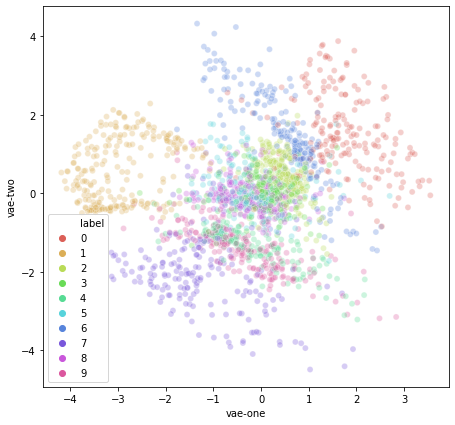

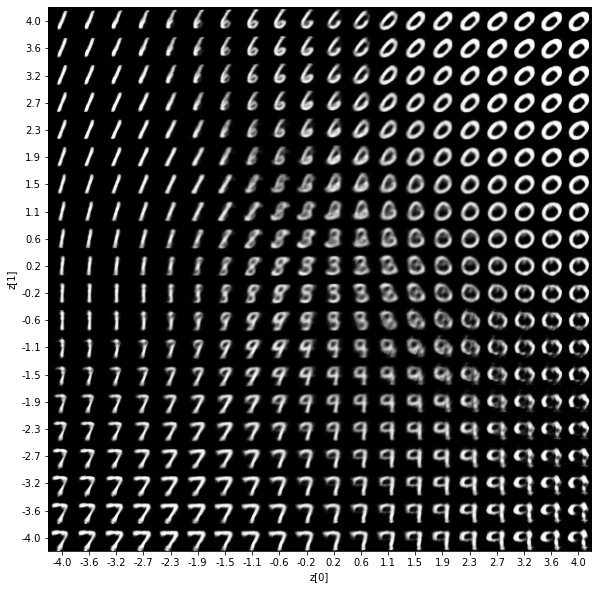

In [50]:
plot_results(models,
             data,
             batch_size=batch_size,
             model_name="vae_mlp")

### Section 6: Analysis

In [67]:
# Zero-mean and feature scaling on all data
# Function featureScale - Perform feature scaling on all of the different method's low-dim data
def featureScale(columnName):
    col_unnormalized = df_subset_test[columnName]
    # Get all features between -1 and 1
    col_scaled = (col_unnormalized - np.amin(col_unnormalized)) / (np.amax(col_unnormalized) - np.amin(col_unnormalized))
    # Get all features to have a minimum of zero
    col_zeroMean = (col_scaled - np.mean(col_scaled)) / (np.amax(col_scaled) - np.amin(col_scaled))
    df_subset_test['{}-scaled'.format(columnName)] = col_zeroMean

featureScale('vae-one')
featureScale('vae-two')

In [68]:
print(df_subset_test)

      pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  pixel8  pixel9  \
3164     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
9808     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
7444     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
6244     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
4989     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
...      ...     ...     ...     ...     ...     ...     ...     ...     ...   
7828     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
3761     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
6011     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
7090     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
9761     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   

      pixel10  ...  pixel780  pixel781 

In [75]:
# Function to compute the interclass and intraclass distance of a method's latent space
# Variables col1 and col2 represent a certain method's computed x1 and x2 features
def classDistance(col1, col2):
    
    index1 = df_subset_test.columns.get_loc(col1)
    index2 = df_subset_test.columns.get_loc(col1)
    
    total_intraclass_dist = 0
    centroidArray = [] # Will store information needed to calculate interclass distance

    for i in range(10):
       
        centroid_x1, centroid_x2, counter = findCentroidCoords(i, index1, index2)
        centroidArray.append([centroid_x1, centroid_x2, counter]) #Add this centroid to the array
        
        totaldist_x1 = 0
        totaldist_x2 = 0
        intraclass_dist = 0

        for example in df_subset_test.T.iteritems():
            if example[1][784] == i:
                totaldist_x1 = totaldist_x1 + abs(centroid_x1 - example[1][index1])
                totaldist_x2 = totaldist_x2 + abs(centroid_x2 - example[1][index2])

        intraclass_x1 = totaldist_x1 / counter;
        intraclass_x2 = totaldist_x2 / counter;

        intraclass_dist = intraclass_dist + (intraclass_x1 ** 2 + intraclass_x2 ** 2) ** 0.5
        total_intraclass_dist = total_intraclass_dist + intraclass_dist

    avg_interclass_dist = findInterclassDistance(centroidArray)    
    avg_intraclass_dist = total_intraclass_dist / 10 #AVERAGE INTRACLASS DISTANCE FOR THIS APPROACH
    return avg_intraclass_dist, avg_interclass_dist


def findCentroidCoords(i, index1, index2):
    sum_x1 = 0
    sum_x2 = 0
    counter = 0

    for example in df_subset_test.T.iteritems():
        if example[1][784] == i:
            counter = counter + 1;
            sum_x1 = sum_x1 + example[1][index1]
            sum_x2 = sum_x2 + example[1][index2]

    centroid_x1 = sum_x1 / counter
    centroid_x2 = sum_x2 / counter
    return centroid_x1, centroid_x2, counter

# A function to find the average weighted distance between all centroids in a given approach
def findInterclassDistance(centroidArray):
    total_interclass_dists = 0
    for index1 in range(len(centroidArray)):
        weight = centroidArray[index1][2] #The count represents the weight of this centroid
        x1coord = centroidArray[index1][0]
        x2coord = centroidArray[index1][1]
        this_interclass_dist = 0    
        
        for index2 in range(len(centroidArray)):
            other_x1coord = centroidArray[index2][0]
            other_x2coord = centroidArray[index2][1] 
            # accumulates sum of distances from index1's centroid to all other centroids
            weightedDist = weight * (((x1coord - other_x1coord) ** 2 + (x1coord - other_x1coord) ** 2 ) ** 0.5)
            this_interclass_dist = this_interclass_dist + weightedDist
            
        
        # Average interclass distance from index1's centroid to all the other centroids
        this_interclass_avg = this_interclass_dist / 10
        total_interclass_dists = total_interclass_dists + this_interclass_avg
        
    avg_interclass_dist = total_interclass_dists / 10 #AVERAGE INTERCLASS DISTANCE OF ALL CENTROIDS FOR THIS APPROACH
    return avg_interclass_dist

In [77]:
vae_intra, vae_inter = classDistance('vae-one-scaled', 'vae-two-scaled')

print('VAE interclass distance: {}'.format(vae_inter))
print('VAE intraclass distance: {}'.format(vae_intra))

VAE interclass distance: 43.70278857921967
VAE intraclass distance: 0.10446293771085229


### Section 7: Conclusion

##### Here is how VAE fits into my study of Latent Space

#### Results -  MNIST Digits

| DR Algorithm | Intraclass distance | Interclass distance |  | Intraclass distance w/ PCA50 | Interclass distance w/ PCA50|
| --- | --- | --- | | --- | --- | 
| PCA | 0.1846839432781619| 0.2514883636037526 |  | TBD | TBD | 
| AutoEncoder | TBD  | TBD |  | TBD | TBD | |  |  |  |  |  |
| VAE | 0.10446293771085229 |  43.70278857921967 |   | TBD | TBD |  |  | |  |  |  |
| CVAE | 0.07370805122572618 | 0.16102034277326321 |  | TBD | TBD | 
| t-SNE | 0.2913386100985398 | 0.42389463159368007 | | TBD | TBD | 
| UMAP | 0.3399398323304261 | 0.3990936375442698 | | TBD | TBD | 

#### Results - Fashion MNIST 

| DR Algorithm | Intraclass distance | Interclass distance | | Intraclass distance w/ PCA50 | Interclass distance w/PCA50 |
| --- | --- | --- | ---  | --- | --- |
| PCA | 0.28360059659323616 | 0.3035366965023135 |  | TBD | TBD | 
| AutoEncoder | TBD | TBD | | TBD | TBD |
| VAE | TBD | TBD || TBD | TBD |
| CVAE | 0.16877078487746006 | 0.16877078487746006 |  | TBD | TBD | 
| t-SNE | 0.2874850425821715 | 0.4589765706187342 |  | TBD | TBD | 
| UMAP | 0.4233480483140607| 0.44498628134312995 | | TBD | TBD |